In [1]:
from pathlib import Path
from cryptocmd import CmcScraper
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from talib import RSI, BBANDS, MACD
DATA_STORE = Path('assets.h5')
choices = ['ETH','USDC']

# Algorithmic trading
Algorithmic trading strategies are driven by signals that indicate when to buy or sell assets to generate superior returns relative to a benchmark, such as an index. The portion of an asset's return that is not explained by exposure to this benchmark is called alpha, and hence the signals that aim to produce such uncorrelated returns are also called alpha factors. Alpha factors are transformations of raw data that aim to predict asset price movements. They are designed to capture risks that drive asset returns

# Task
Goal: long-only cash + long-only instrument.


To produce a long-only trading strategy utilizing two instruments based on price and volume with one day
sampling. One instrument is a stock or a cryptocurrency, and the other is a cash instrument such as the dollar or a
stable coin.


The term long position describes what an investor has purchased when they buy a security or derivative with the expectation that it will rise in value.

In [2]:
def derive_crypto(cryptoname):
    # initialise scraper without time interval
    scraper = CmcScraper(cryptoname)
    # get raw data as list of list
    headers, data = scraper.get_data()
    # get data in a json format
    xrp_json_data = scraper.get_data("json")
    # export the data as csv file, you can also pass optional `name` parameter
    scraper.export("csv", name= cryptoname + "_all_time")
    # Pandas dataFrame for the same data
    df = scraper.get_dataframe()
    df.set_index('Date',inplace=True)
    df.drop(['Market Cap'], axis=1, inplace=True)
    with pd.HDFStore(DATA_STORE) as store:
        store.put(cryptoname, df)

In [3]:
for cryp in choices:
    derive_crypto(cryp)

# Investigate at least 4 different alpha signals, potentially combining them.
- One should be a momementum strategy based on detecting a trend and buying early in an up-trend,
and selling early in a down-trend
- Another should be a mean reversion strategy based on noting that a price has gone up too fast even considering a trend, and that it will go down (sell signal) or that the price has dropped to far given a trend (buy the dip signal).
-  Two more strategies should be investigated, either as variants on the above two or using volume
signals. Consider moving avarages, bollinger bands, RSI and other indicators particularly from the
python library TA-Lib.

## Creating the dataset 

In [4]:
with pd.HDFStore(DATA_STORE) as store:
    eth = store[choices[0]]
    usdc = store[choices[1]]

In [5]:
eth

,Open,High,Low,Close,Volume
Date,,,,,
2022-04-10,3261.291417,3303.003095,3211.866884,3211.866884,1.042705e+10
2022-04-09,3191.976016,3261.963103,3187.469209,3261.916171,9.908112e+09
2022-04-08,3233.272402,3301.607533,3179.142428,3192.074044,1.755705e+10
2022-04-07,3172.197361,3263.474558,3155.580992,3233.274707,1.674550e+10
2022-04-06,3411.672097,3411.672097,3171.204968,3171.692010,2.563256e+10
...,...,...,...,...,...
2015-08-11,0.708087,1.131410,0.663235,1.067860,1.463100e+06
2015-08-10,0.713989,0.729854,0.636546,0.708448,4.052830e+05
2015-08-09,0.706136,0.879810,0.629191,0.701897,5.321700e+05


In [5]:
eth.shape

(2434, 5)

In [7]:
eth

,Open,High,Low,Close,Volume
Date,,,,,
2022-04-05,3521.239783,3546.706857,3410.547512,3411.792509,1.668150e+10
2022-04-04,3522.364931,3535.148077,3422.001030,3521.241137,1.820997e+10
2022-04-03,3444.810663,3573.960243,3421.259779,3522.833400,1.533381e+10
2022-04-02,3449.788662,3521.284678,3442.000160,3445.059371,2.357156e+10
2022-04-01,3282.576168,3467.555908,3223.891304,3449.552130,2.098299e+10
...,...,...,...,...,...
2015-08-11,0.708087,1.131410,0.663235,1.067860,1.463100e+06
2015-08-10,0.713989,0.729854,0.636546,0.708448,4.052830e+05
2015-08-09,0.706136,0.879810,0.629191,0.701897,5.321700e+05


## Momentum factors
To capture time-series dynamics like momentum patterns, we compute historical multi- period returns using the pct_change(n_periods) method, where n_periods identifies the number of lags. 

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [8]:
monthly_prices = eth.resample('M').last()
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x:
                                 x.clip(lower=x.quantile(outlier_cutoff),
                                        upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3- and 12-month returns, as follows:

In [11]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345 entries, ('Open', Timestamp('2016-08-31 00:00:00', freq='M')) to ('Volume', Timestamp('2022-04-30 00:00:00', freq='M'))
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      345 non-null    float64
 1   return_2m      345 non-null    float64
 2   return_3m      345 non-null    float64
 3   return_6m      345 non-null    float64
 4   return_9m      345 non-null    float64
 5   return_12m     345 non-null    float64
 6   momentum_2     345 non-null    float64
 7   momentum_3     345 non-null    float64
 8   momentum_6     345 non-null    float64
 9   momentum_9     345 non-null    float64
 10  momentum_12    345 non-null    float64
 11  momentum_3_12  345 non-null    float64
dtypes: float64(12)
memory usage: 36.0+ KB


In [13]:
print(data.head(1).index)
print(data.tail(1).index)
print(data.shape)
print(data.info())

MultiIndex([('Open', '2016-08-31')],
           names=[None, 'Date'])
MultiIndex([('Volume', '2022-04-30')],
           names=[None, 'Date'])
(345, 12)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345 entries, ('Open', Timestamp('2016-08-31 00:00:00', freq='M')) to ('Volume', Timestamp('2022-04-30 00:00:00', freq='M'))
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      345 non-null    float64
 1   return_2m      345 non-null    float64
 2   return_3m      345 non-null    float64
 3   return_6m      345 non-null    float64
 4   return_9m      345 non-null    float64
 5   return_12m     345 non-null    float64
 6   momentum_2     345 non-null    float64
 7   momentum_3     345 non-null    float64
 8   momentum_6     345 non-null    float64
 9   momentum_9     345 non-null    float64
 10  momentum_12    345 non-null    float64
 11  momentum_3_12  345 non-null    float64
dtypes: float64(12)
memor

#### Creating features
If you want to use lagged returns, that is, returns from previous periods as input variables or features to train a model that learns return patterns to predict future returns, you can use the .shift() method to move historical returns up to the current period. The following example moves the returns for the periods 1 to 6 months ago up by the corresponding lag so that they are associated with the observation for the current month. 

Use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [16]:
data.head(6)

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,momentum_2,momentum_3,momentum_6,momentum_9,momentum_12,momentum_3_12
,Date,,,,,,,,,,,,
Open,2016-08-31,-0.096554,-0.055676,-0.041024,0.096803,0.327141,0.195291,0.040877,0.055530,0.193357,0.423695,0.291845,0.236315
High,2016-08-31,-0.066316,-0.042568,-0.064516,0.099408,0.330319,0.193649,0.023748,0.001800,0.165724,0.396635,0.259965,0.258165
Low,2016-08-31,-0.031462,-0.044645,-0.040032,0.107699,0.331937,0.204353,-0.013183,-0.008570,0.139161,0.363399,0.235815,0.244385
Close,2016-08-31,-0.017136,-0.032179,-0.060536,0.107166,0.333892,0.196324,-0.015044,-0.043400,0.124302,0.351028,0.213459,0.256859
Volume,2016-08-31,-0.550219,-0.162856,-0.262535,0.063630,0.341987,0.184807,0.387363,0.287684,0.613849,0.892206,0.735026,0.447342
Open,2016-09-30,0.163490,0.025256,0.012360,0.015549,0.344289,0.282367,-0.138234,-0.151131,-0.147941,0.180799,0.118877,0.270007


In [17]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.return_1m.shift(t)

#### Creating targets
Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features. Similarly, you can create forward returns for the current period, that is, returns that will occur in the future, using .shift() with a negative period (assuming your data is sorted in ascending order):

In [18]:
data

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,momentum_2,momentum_3,momentum_6,momentum_9,momentum_12,momentum_3_12,return_1m_t-1,return_1m_t-2,return_1m_t-3,return_1m_t-4,return_1m_t-5,return_1m_t-6
,Date,,,,,,,,,,,,,,,,,,
Open,2016-08-31,-0.096554,-0.055676,-0.041024,0.096803,0.327141,0.195291,0.040877,0.055530,0.193357,0.423695,0.291845,0.236315,NaN,NaN,NaN,NaN,NaN,NaN
High,2016-08-31,-0.066316,-0.042568,-0.064516,0.099408,0.330319,0.193649,0.023748,0.001800,0.165724,0.396635,0.259965,0.258165,-0.096554,NaN,NaN,NaN,NaN,NaN
Low,2016-08-31,-0.031462,-0.044645,-0.040032,0.107699,0.331937,0.204353,-0.013183,-0.008570,0.139161,0.363399,0.235815,0.244385,-0.066316,-0.096554,NaN,NaN,NaN,NaN
Close,2016-08-31,-0.017136,-0.032179,-0.060536,0.107166,0.333892,0.196324,-0.015044,-0.043400,0.124302,0.351028,0.213459,0.256859,-0.031462,-0.066316,-0.096554,NaN,NaN,NaN
Volume,2016-08-31,-0.550219,-0.162856,-0.262535,0.063630,0.341987,0.184807,0.387363,0.287684,0.613849,0.892206,0.735026,0.447342,-0.017136,-0.031462,-0.066316,-0.096554,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Open,2022-04-30,0.040159,0.159044,0.105925,-0.033602,0.040581,0.020576,0.118885,0.065766,-0.073761,0.000422,-0.019583,-0.085350,-0.082042,0.124158,0.265446,0.172727,0.291517,0.398301
High,2022-04-30,0.032482,0.100372,0.095491,-0.035090,0.037286,0.020015,0.067891,0.063009,-0.067572,0.004805,-0.012466,-0.075475,0.040159,-0.082042,0.124158,0.265446,0.172727,0.291517
Low,2022-04-30,0.042046,0.148326,0.110697,-0.033300,0.038677,0.018778,0.106280,0.068651,-0.075346,-0.003369,-0.023268,-0.091919,0.032482,0.040159,-0.082042,0.124158,0.265446,0.172727


In [21]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = (data
                            [f'return_{t}m'].shift(-t))

#### Adding momentum factors
We can use the 1-month and 3-month results to compute simple momentum factors. The following code example shows how to compute the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3- and 12-month returns:

## Create technical alpha factors

In [6]:
up, mid, low = BBANDS(eth.Close, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
rsi = RSI(eth.Close, timeperiod=14)
data = pd.DataFrame({'AAPL': eth.Close, 'BB Up': up, 'BB Mid': mid, 'BB down': low, 'RSI': rsi})

### Bollinger Bands
<strong>Bollinger Bands</strong> consist of a simple moving average (SMA) surrounded by bands
two rolling standard deviations below and above the SMA. This visualization represents the potential of overbought/oversold conditions when the price dipped outside the two bands on the upper or lower side, respectively.

<strong>Overbought</strong> generally describes recent or short-term movement in the price of the security, and reflects an expectation that the market will correct the price in the near future. This belief is often the result of technical analysis of the security’s price history, but fundamentals may also be employed. A stock that is overbought may be a good candidate for sale.

The term <strong>oversold</strong> refers to a condition where an asset has traded lower in price and has the potential for a price bounce. An oversold condition can last for a long time, and therefore being oversold doesn't mean a price rally will come soon, or at all.

### RSI
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. 


Traditional interpretation and usage of the RSI are that values of 70 or above indicate that a security is becoming overbought or overvalued and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an oversold or undervalued condition.

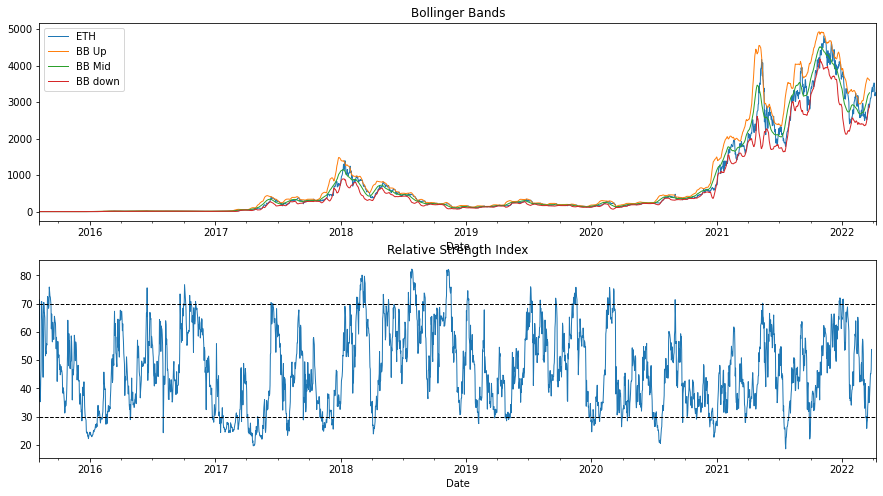

In [7]:
data = pd.DataFrame({'ETH': eth.Close, 'BB Up': up, 'BB Mid': mid,
                     'BB down': low, 'RSI': rsi})
fig, axes= plt.subplots(nrows=2, figsize=(15, 8))
data.drop('RSI', axis=1).plot(ax=axes[0], lw=1, title='Bollinger Bands')
data['RSI'].plot(ax=axes[1], lw=1, title='Relative Strength Index')
axes[1].axhline(70, lw=1, ls='--', c='k')
axes[1].axhline(30, lw=1, ls='--', c='k')

# Zipline for backtests

We are first going to illustrate the Zipline alpha factor research workflow in an offline environment. In particular, we will develop and test a simple mean-reversion factor that measures how much recent performance has deviated from the historical average.

Short-term reversal is a common strategy that takes advantage of the weekly predictive pattern that stock prices are likely to revert back to a rolling mean over horizons from less than 1 minute to 1 month.

To this end, the factor computes the z-score for the last monthly return relative to the rolling monthly returns over the last year. At this point, we will not place any orders to simply illustrate the implementation of a CustomFactor and record the results during the simulation

In [8]:
%load_ext zipline

In [9]:
#%%zipline --start 2015-1-1 --end 2018-1-1 --output single_factor.pickle --no-benchmark --bundle quandl

from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
import numpy as np
import pandas as pd

MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 1000


class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())


def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS),
                             'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)


def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')